In [17]:
import random

import pandas as pd
import torch
from matplotlib import pyplot as plt
from torch.nn import *
from torch.optim import *

from model import LSTMModel

Read Preprocessed Dataset 

In [18]:
path = './data/knn_clean_data.csv'
df = pd.read_csv(path)
# select relevant features
moods = df[['mood', 'ID']]
# process id and mood
moods = pd.get_dummies(moods, columns=['ID'])
# moods['mood'] = moods['mood'].round().astype(int)
# print(moods['mood'].value_counts())

In [19]:
# define hyper-parameters
hidden_size = 128  # 隐藏层维度
num_layers = 2  # LSTM层数
output_size = 1  # 输出维度
num_epochs = 1000  # 迭代次数
learning_rate = 1e-2  # 学习率
max_grad_norm = 10.0

seq_length = 7
batch_size = 32
step = 2
# generate dataset
ids = df['ID'].unique()
id_moods = []
for uid in ids:
    uid = 'ID_' + uid
    id_mood = moods[moods[uid] == 1]
    id_moods.append(id_mood)
# remove data that is not continuous
id_moods[0] = id_moods[0][2:]

dataset = []
for id_mood in id_moods:
    id_dataset = [id_mood[i:i + seq_length + 1] for i in range(0, len(id_mood) - seq_length, step)]
    id_dataset = [df.to_numpy() for df in id_dataset]
    dataset += id_dataset

print('dataset size:', len(dataset))
# split it into train set and test set.
random_indices = random.sample(range(len(dataset)), k=int(len(dataset) / 5))
train_set = []
test_set = []

for i in range(len(dataset)):
    if i in random_indices:
        test_set.append(dataset[i])
    else:
        train_set.append(dataset[i])
print('train set size:',len(train_set))
print('test set size:', len(test_set))

X_train = [element[:seq_length] for element in train_set]
y_train = [element[seq_length:][0][:1] for element in train_set]
X_test = [element[:seq_length] for element in test_set]
y_test = [element[seq_length:][0][:1] for element in test_set]
# convert them into Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

dataset size: 544
train set size: 436
test set size: 108


In [20]:
# 定义参数
input_size = X_train.shape[-1]  # 输入维度
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 创建模型并将其移动到设备上
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
# 定义损失函数和优化器
# criterion = CrossEntropyLoss()
criterion = MSELoss()
# optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.1)
optimizer = RMSprop(model.parameters(), lr=learning_rate)

loss_history = []
test_loss_history = []
train_acc_history = []

# 训练模型
for epoch in range(num_epochs):
    total_loss = 0
    total_sample = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i + batch_size].to(device)
        targets = y_train[i:i + batch_size].to(device)
        inputs_size = len(inputs)
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        total_sample += inputs_size
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        # 剪枝
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        
    total_loss = total_loss / total_sample
    loss_history.append(total_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss:.4f}')
        # 模型评估
        total_loss = 0
        total_sample = 0
        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                inputs = X_test[i:i + batch_size].to(device)
                targets = y_test[i:i + batch_size].to(device)
                
                outputs = model(inputs)
                loss = criterion(targets, outputs)
                
                # print('outputs:', outputs.transpose(0,1))
                # print('labels:', targets.transpose(0,1))
                
                inputs_size = len(inputs)
                total_loss += loss.item()
                total_sample += inputs_size
            avg_loss = total_loss / total_sample
            print(f'Test Loss : { avg_loss:.4f}')
            test_loss_history.append(avg_loss)

            # correct = 0
            # total = 0
            # for i in range(0, len(X_train), batch_size):
            #     inputs = X_train[i:i + batch_size].to(device)
            #     targets = y_train[i:i + batch_size].to(device)
            #     targets = targets.transpose(0, 1)
            #     outputs = model(inputs)
            #     _, predicted = torch.max(outputs.data, 1)
            #     total += targets.size(1)
            #     correct_matrix = (predicted == targets)
            #     correct += (predicted == targets).sum().item()
            # print(f'Accuracy on train set: {100 * correct / total:.2f}%')
            # train_acc_history.append(100 * correct / total)
    

Epoch [10/1000], Loss: 0.0694
Test Loss : 0.0622
Epoch [20/1000], Loss: 0.0423
Test Loss : 0.0463
Epoch [30/1000], Loss: 0.0344
Test Loss : 0.0346
Epoch [40/1000], Loss: 0.0293
Test Loss : 0.0388
Epoch [50/1000], Loss: 0.0292
Test Loss : 0.0401
Epoch [60/1000], Loss: 0.0274
Test Loss : 0.0323
Epoch [70/1000], Loss: 0.0334
Test Loss : 0.0419
Epoch [80/1000], Loss: 0.0278
Test Loss : 0.0440
Epoch [90/1000], Loss: 0.0244
Test Loss : 0.0392
Epoch [100/1000], Loss: 0.0263
Test Loss : 0.0237
Epoch [110/1000], Loss: 0.0241
Test Loss : 0.0369
Epoch [120/1000], Loss: 0.0275
Test Loss : 0.0291
Epoch [130/1000], Loss: 0.0220
Test Loss : 0.0292
Epoch [140/1000], Loss: 0.0208
Test Loss : 0.0542
Epoch [150/1000], Loss: 0.0207
Test Loss : 0.0296
Epoch [160/1000], Loss: 0.0191
Test Loss : 0.0257
Epoch [170/1000], Loss: 0.0151
Test Loss : 0.0260
Epoch [180/1000], Loss: 0.0161
Test Loss : 0.0326
Epoch [190/1000], Loss: 0.0155
Test Loss : 0.0237
Epoch [200/1000], Loss: 0.0188
Test Loss : 0.0294
Epoch [21

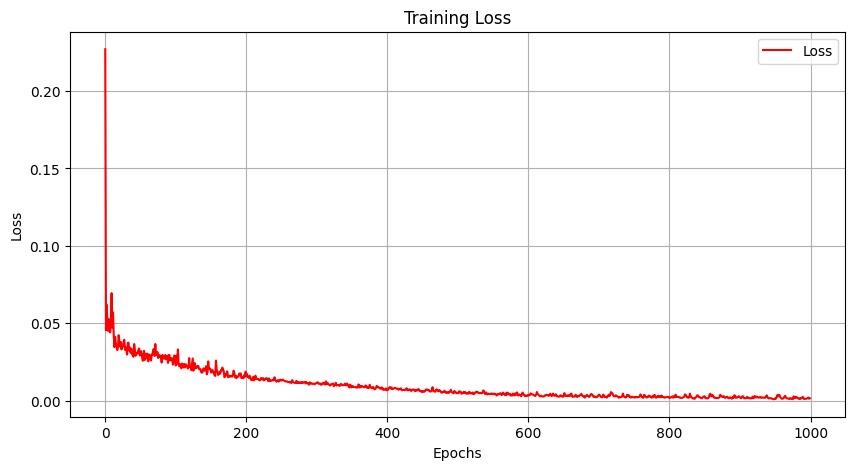

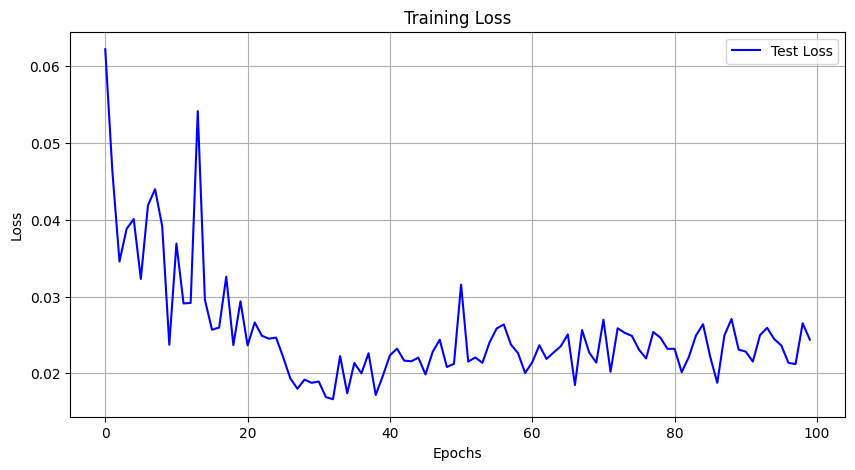

In [21]:
# visualization
plt.figure(figsize=(10, 5))
plt.plot(loss_history, 'r', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 绘制准确率图像
plt.figure(figsize=(10, 5))
plt.plot(test_loss_history, 'b', label='Test Loss')
# plt.plot(train_acc_history, 'r', label='Train Accuracy')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()